In [1]:
# import different de ceux tout en haut pour ne rien toucher a ce qui marche
import numpy as np

import random

from collections import Counter

from math import floor,modf,sqrt,log

from scipy.spatial.distance import cdist,mahalanobis
from scipy.stats import cauchy,chi2,mode

from KMOM import *

from sklearn import datasets
from sklearn.cluster import DBSCAN,Birch
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import LocalOutlierFactor

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import time

# import skfuzzy as fuzz
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer


In [2]:
def mapping(target_lbl,clusters):
    '''
    Dictionary which maps the number cluster to the most probable label
    true_label: list of true partition
    cluster   : fitted clusters
    K         : number of clusters
    '''
    mymap = {}
    for i in set(clusters):
        mask = (clusters == i)
        mymap[i] = mode(target_lbl[mask])[0][0]
    return(mymap)
        
    
def RMSE(centers,centroids_hat,mapp):
    '''
    centers: theoritical centers
    centers_hat: fitted centroids
    '''
    k,p = centers.shape
    incr = 0
    for cluster, label in mapp.items():
        incr += sum((centroids_hat[cluster] - centers[label])**2)
    return((incr/k)**0.5)

def accuracy(true_label,cluster,mapp):
    labels = [mapp[clu] for clu in cluster]
    return(accuracy_score(true_label, labels))

def convert_to_y_pred(clusters):
    y_true=[0]*n_data
    for j in range(len(clusters)):
        for index in clusters[j]:
            y_true[index]=j
    return(np.array(y_true))

def def_centers(p,mu):
    # dimension de l'entree
    K,dim=mu.shape
    # les centres en dimension p
    centers=np.zeros((K,p))
    for k in range(K):
            for j in range(dim):
                centers[k,j]=mu[k,j]
    return(centers)

def data_clustered_outliers(n_samples,n_outliers,p,centers = np.array([[1,4],[2,1],[-2,3]]),centers_outliers=np.array([[7,7]]),it_=0):
    # initialisation des parametres
    centers=def_centers(mu=centers,p=p)
    centers_outliers=def_centers(mu=centers_outliers,p=p)
    K           = len(centers)              # nombre de classes
    sig         = 0.6                       # within variance
    # Generation des donnees
    Xinlier, y_inlier = make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.60, random_state=it_)
    # Outliers creation
    Xoutlier, y_outlier = make_blobs(n_samples=n_outliers, centers=centers_outliers, cluster_std=0.60)
    # all concatenante
    n_data=n_samples+n_outliers
    X = np.concatenate([Xoutlier,Xinlier], axis=0)
    y_true=np.concatenate([y_outlier+K,y_inlier])
#     plt.plot(X[:,0],X[:,1],'b.')
    return({'points':X,'partition':y_true,"centers":centers})

def bloc_size(n_data,n_outliers,p,alpha=0.05,complexity_param=None,bloc_size_mini=0):
    '''
    Function which fits the maximum size of the blocks such that the theoretical complexity of the creation
    of all the blocks is equal to the one of the computation of the assignment of all the data points to their
    centers. This maximum size is always smaller that the statistical breakdown size.
    ```prms```
    n_sample         : nb of data
    n_outlier        : nb of outliers
    p                : dimension of the problem
    alpha            : threshold confidence
    complexity_param : set the block creation to be at most 'complexity_param' times computationnaly more complexe
                       than assigning each data points to their closest center
    '''
    max_possible_block_size=floor(log(0.5)/log(1-n_outliers/n_data))
    print("maximal admissible block size = ",max_possible_block_size)
    borne_inf_beta=-2*(1/p+1/(n_samples+n_outliers))*log(alpha)
    n_data=n_data+n_outliers
    
    if complexity_param==None:
        complexity_param=30*borne_inf_beta
        
    if complexity_param<=1:
        print("complexity_param were too small")
        return()
    else:
        facteur=complexity_param*borne_inf_beta
        bloc_size_max_complexity = floor(log(0.5+sqrt(-0.5*log(alpha)*(1/n_data+1/p)/facteur))/log(1-n_outliers/n_data))
    
    if bloc_size_mini>0:
        if bloc_size_mini>0.9*max_possible_block_size:
            print("WARNING : the minimum size of block given by bloc_size_mini is too big and will cause very long running time")
            
    res=max(min(bloc_size_mini,max_possible_block_size),bloc_size_max_complexity)
    return(res)

def bloc_nb(n_data,n_outliers,p,b_size=None,alpha=0.05,block_complexity_param=100,bloc_size_mini=None):
    '''
    Function which fits the minimum nb of blocks for a given size t such that the breakdown
    point is not attained and such that the theoretical complexity of the creation of all the
    blocks equals the complexity of computing the assignment of all the data points to the centers
    ```prms```
    b_size    = bloc_size
    n_sample  : nb of data
    n_outlier : nb of outliers
    p         : dimension of the problem
    alpha     : threshold confiance
    '''
    if n_outliers/n_data >= 0.5:
        print('too much noise')
        return()
    elif b_size == None:
        t = bloc_size(n_data,n_outliers,p,alpha=alpha,complexity_param=block_complexity_param,bloc_size_mini=None)
    else:
        t = b_size
    
    return(1+floor(log(1/alpha) / (2* ((1-n_outliers/n_data)**t - 1/2)**2)))

def dist_to_t(XA,rr):
    '''
    XA = np.array 1D
    rr = np.array 1D
    to fit the shape that arguments will have when using np.apply_along_axis
    '''
    XAA=XA.reshape(1,-1) # convert to 2D array to fit cdist() format
    rrr=rr.reshape(1,-1) # convert to 2D array to fit cdist() format
    res=cdist(XA=XAA,XB=rrr)[0]
    return(res)

def dist_to_centers(vector,centers):
    '''
    vector  = 1D array
    centers = 1D or 2D array
    returns a 1D array with all distances between the vector and the centers
    '''
    res=np.apply_along_axis(arr=centers,axis=1,func1d=dist_to_t,rr=vector).reshape(1,-1)[0]
    return(res)

def dist_vec_to_centers(X,centers):
    '''
    X       = 1D or 2D array
    centers = 1D or 2D array
    returns a 1D or 2D array with all distances between each rows of X and the centers
    the rows of the output corresponds to rows of X and column to the centers
    '''
    res=np.apply_along_axis(arr=X,axis=1,func1d=dist_to_centers,centers=centers)
    return(res)

def init_ROBIN( X,k,
                method="optimum",epsilon=0.05,determinist=True,
                n_neighbors=20, algorithm='auto', leaf_size=30,
                metric='minkowski', p=2, metric_params=None,
                contamination="legacy", novelty=False, n_jobs=None):
    
    if not(any(method==np.array(["optimum","minimum","approx"]))):
        print("'method' should be either 'optimum', 'minimum' or 'approx', default 'optimum'. When 'approx' is chosen, give a value for epsilon, default 0.05")
    
    
    # initialization of variables
    n,p=X.shape
    if determinist==True:
        origine=np.tile(A=0,reps=p).reshape(1,p);origine
#         centers=np.array([[]]).reshape(0,p).shape
        centers_index=[] # we will return the indexes for more convenience
        m=0;m
    else:
        index_first_center=np.random.choice(np.arange(n),size=1,replace=False)[0]
        centers_index=[index_first_center] # we will return the indexes for more convenience
        centers=X[index_first_center,:].reshape(1,p)
        m=1;m
        
    
    # compute the LOF as first step
    init__=LocalOutlierFactor(n_neighbors=n_neighbors, algorithm=algorithm, leaf_size=leaf_size,
                     metric=metric, p=p, metric_params=metric_params,
                     contamination=contamination, novelty=novelty, n_jobs=n_jobs);init__
    LOF_algo_run=init__.fit(X);LOF_algo_run
    LOF_values=-LOF_algo_run.negative_outlier_factor_
    # print("LOF_values="+str(LOF_values))
    
    # search then for k centers
    while m<k:
        #print("m=",m)
        # compute distances to centers except when there is no center yet
        if m==0:
            array_distance=dist_vec_to_centers(X=X,centers=origine).flatten();#print("path 1.1:")
        else:
            if m==1:
                array_distance=dist_vec_to_centers(X=X,centers=centers).flatten();#print("path 1.2:")
            if m >1:
                array_distance=dist_vec_to_centers(X=X,centers=centers).min(axis=1);#print("path 1.3:")
        # find the index order that would sort the distance array
        order=np.flip(m=np.argsort(array_distance),axis=0);order
        
        # search for the next center
        if method=='optimum':
            # Looks for the LOF that is the nearest to 1: one transforms the LOF_values with x->(x-1)^2 and then searchs the min
            position_ordered_LOF_next_nearest_to_1=np.argsort(((LOF_values[order]-1)**2))[m];position_ordered_LOF_next_nearest_to_1
            position_LOF_next_nearest_to_1=order[position_ordered_LOF_next_nearest_to_1];position_LOF_next_nearest_to_1
            centers_index.append(position_LOF_next_nearest_to_1);centers_index
            point_LOF_next_nearest_to_1=X[position_LOF_next_nearest_to_1,:];point_LOF_next_nearest_to_1
            if m==0:
                centers=point_LOF_next_nearest_to_1.reshape(1,p);#print("path 2.1 : ",centers)
            else:
                centers=np.concatenate([centers,point_LOF_next_nearest_to_1.reshape(1,p)]);#print("path 2.2 : ",centers)
        elif method=='minimum':
            # Looks for the LOF that is minimum
            position_ordered_LOF_next_min=np.argsort(LOF_values[order])[m];position_ordered_LOF_next_min
            position_LOF_next_min=order[position_ordered_LOF_next_min];position_LOF_next_min
            centers_index.append(position_LOF_next_min)
            point_LOF_next_min=X[position_LOF_next_min,:];point_LOF_next_min
            if m==0:
                centers=point_LOF_next_min.reshape(1,p)
            else:
                centers=np.concatenate([centers,point_LOF_next_min.reshape(1,p)])
        elif method=="approx":
            # Looks for the first LOF value that falls in ]1-eps,1+eps[
            i=0
            stopping_crit=True
            while stopping_crit:
                if i<n:
                    # it is indeed possible that one has pointed at all LOF values while centers are still missing.
                    # this situation means that the intervalle ]1-eps,1+eps[ contains too few points to be centers.
#                     print(i,end='')
                    if abs(LOF_values[order[i]]-1)<epsilon and not(any(order[i]==centers_index)):
                        centers_index.append(order[i])
                        if m==0:
                                centers=X[order[i],:].reshape(1,p)
                        else:
                                centers=np.concatenate([centers,X[order[i],:].reshape(1,p)])
                        stopping_crit=False
                    else:
                        i=i+1
                else:
                    # all values of LOF have been pointed by the loop and it still misses centers then one uses the 'optimum' method to complet centers 
                    stopping_crit=False
                    method="optimum"
        else:
            print("/!\ unvalid value given for 'method'")
    
        # we now have m+1 centers, we need to increment m
        m=m+1;m
#         print()
    res=np.array(centers_index)
    return(res)

alpha= 0.1
complexity_param= 3


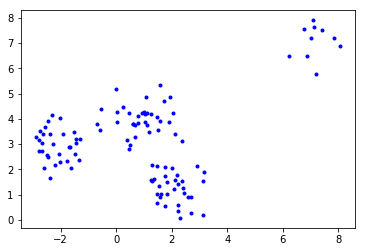

In [3]:
n_samples=100
k=4
K=k
n_outliers=10
# n_out=n_outliers
coef_ech=6
p=2
alpha=n_outliers/n_samples;print("alpha=",alpha)
complexity_param=3;print('complexity_param=',complexity_param)
temp=data_clustered_outliers(n_samples=n_samples,n_outliers=n_outliers,p=2)
X=temp['points']
plt.plot(X[:,0],X[:,1],'b.')

## Example of KMOM output

In [4]:
b_size=int(bloc_size(n_data=n_samples+n_outliers,n_outliers=n_outliers,p=p,alpha=alpha,complexity_param=complexity_param,bloc_size_mini=k));print(b_size)
nb_blocs=int(bloc_nb(n_data=n_samples+n_outliers,n_outliers=n_outliers,p=p,b_size=b_size,alpha=alpha,block_complexity_param=complexity_param));print(nb_blocs)
kmom = KMOMalgo_unif(X=X,K=K,coef_ech=coef_ech,nbr_blocks=nb_blocs,outliers=n_outliers,max_iter=0)
t1=time.time()
res_kmom = kmom.fit(X=X);res_kmom
t2=time.time()
print("cell running time =",t2-t1)

maximal admissible block size =  7
4
35
cell running time = 0.3951752185821533


/home/jupyter/workspace/EdouardResearch/pour_mon_github/KMOM/algoKMOM_v8_4.py:283: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  D_nk_min_rows = D_nk[[np.arange(self.n).tolist(),partition_array.tolist()]]


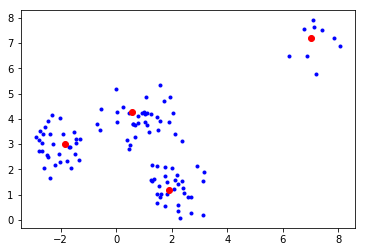

In [5]:
plt.plot(X[:,0],X[:,1],'b.')
plt.plot(res_kmom['Qb_centers'][0][:,0],res_kmom['Qb_centers'][0][:,1],'ro')

## Example output of ROBIN + Images that show the centers ROBIN chose steps after steps

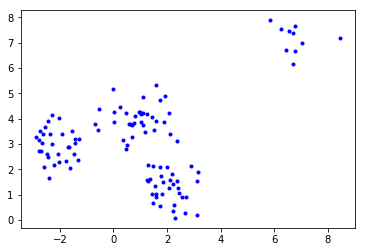

0.013267993927001953


/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


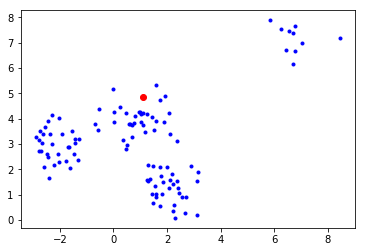

/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


0.021671533584594727


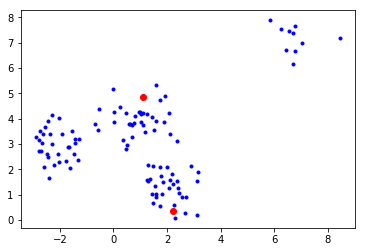

/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


0.02948141098022461


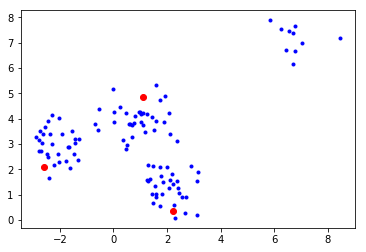

/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


0.056351661682128906


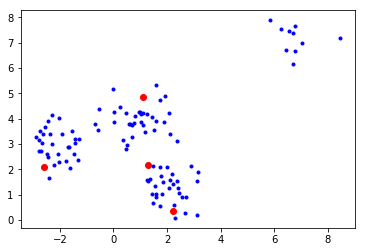

/home/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


0.06232190132141113


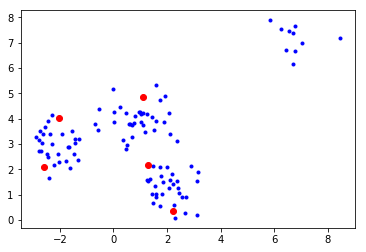

In [6]:
epsilon=0.1 # The first point to be pointed by ROBIN that has LOF in [1-epsilon,1+epsilon] is choosen as next centroids
determinist=True # will the first centroid taken at uniformly at random among data points (False) or according to a criterion that make ROBIN deterministic (True)
ls=30 # Default value in LocalOutlierFactor() see here https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

temp=data_clustered_outliers(n_samples=n_samples,n_outliers=n_outliers,p=2)
X=temp['points']
plt.plot(X[:,0],X[:,1],'b.')
plt.savefig('graph/process_ROBIN_0_ls='+str(ls)+'.png')
plt.show()
plt.plot(X[:,0],X[:,1],'b.')
t1=time.time()
index_center_init=init_ROBIN(X=X,k=1,method="approx",epsilon=epsilon,determinist=determinist,leaf_size=ls);index_center_init
t2=time.time()
print(t2-t1)
plt.plot(X[index_center_init,0],X[index_center_init,1],'ro')
plt.savefig('graph/process_ROBIN_1_ls='+str(ls)+'.png')
plt.show()
plt.plot(X[:,0],X[:,1],'b.')
t1=time.time()
index_center_init=init_ROBIN(X=X,k=2,method="approx",epsilon=epsilon,determinist=determinist,leaf_size=ls);index_center_init
t2=time.time()
print(t2-t1)
plt.plot(X[index_center_init,0],X[index_center_init,1],'ro')
plt.savefig('graph/process_ROBIN_2_ls='+str(ls)+'.png')
plt.show()
plt.plot(X[:,0],X[:,1],'b.')
t1=time.time()
index_center_init=init_ROBIN(X=X,k=3,method="approx",epsilon=epsilon,determinist=determinist,leaf_size=ls);index_center_init
t2=time.time()
print(t2-t1)
plt.plot(X[index_center_init,0],X[index_center_init,1],'ro')
plt.savefig('graph/process_ROBIN_3_ls='+str(ls)+'.png')
plt.show()
plt.plot(X[:,0],X[:,1],'b.')
t1=time.time()
index_center_init=init_ROBIN(X=X,k=4,method="approx",epsilon=epsilon,determinist=determinist,leaf_size=ls);index_center_init
t2=time.time()
print(t2-t1)
plt.plot(X[index_center_init,0],X[index_center_init,1],'ro')
plt.savefig('graph/process_ROBIN_4_ls='+str(ls)+'.png')
plt.show()
plt.plot(X[:,0],X[:,1],'b.')
t1=time.time()
index_center_init=init_ROBIN(X=X,k=5,method="approx",epsilon=epsilon,determinist=determinist,leaf_size=ls);index_center_init
t2=time.time()
print(t2-t1)
plt.plot(X[index_center_init,0],X[index_center_init,1],'ro')
plt.savefig('graph/process_ROBIN_5_ls='+str(ls)+'.png')
plt.show()